# Machine Translation using RNN GRU

We will use spa.txt as training set which has a translation of English words to Spanish words. The database can be downloaded from the URL https://www.dropbox.com/s/poqpk4528x4nkp3/spa.txt


*Workflow:*

1. Understanding the problem
2. Collecting the data
3. Data preprocessing 
4. Build seq2seq Model using Grated Recurrent Unit (GRU)
5. Training the dataset
6. Translate


## 1. Understanding the problem 
The problem statement is to translate the English text into Spanish. For this purpose, we will be using RNN-GRU model using sequence modeling. 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
!wget https://www.dropbox.com/s/poqpk4528x4nkp3/spa.txt #Download the datafile from this site

--2021-05-28 11:19:10--  https://www.dropbox.com/s/poqpk4528x4nkp3/spa.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/poqpk4528x4nkp3/spa.txt [following]
--2021-05-28 11:19:11--  https://www.dropbox.com/s/raw/poqpk4528x4nkp3/spa.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb86d4c90e4e188f09fea194b9b.dl.dropboxusercontent.com/cd/0/inline/BPUs-tRyTd6fmlgx91sByzWKzqP5qxKJvf0ijPcS4kgsI8nn_zpD37dgPtTs6RBZT68wfJU5_fdLyQvyUbTlV_3ObqMXPo8nW7jE4pEpg2UiufPAUvgnknBknnZS5LuLaR-BfZZ6Cmr8lM8v077nGW5Y/file# [following]
--2021-05-28 11:19:11--  https://ucb86d4c90e4e188f09fea194b9b.dl.dropboxusercontent.com/cd/0/inline/BPUs-tRyTd6fmlgx91sByzWKzqP5qxKJvf0ijPcS4kgsI8nn_zpD37dgPtTs6RBZT68wfJU5_fdLyQvyUbTlV_3ObqMXPo8nW7jE4pEpg

In [ ]:
fi = open("spa.txt", encoding = 'utf-8', mode ='r')
data = fi.read()


In [ ]:
data[:50]

'Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVÃ¡yase.\nHi.\tHola.'

In [ ]:
df=[]
for line in data.split('\n'):
  df.append(line.split('\t'))

In [ ]:
print(df[:20])

[['Go.', 'Ve.'], ['Go.', 'Vete.'], ['Go.', 'Vaya.'], ['Go.', 'VÃ¡yase.'], ['Hi.', 'Hola.'], ['Run!', 'Â¡Corre!'], ['Run!', 'Â¡Corran!'], ['Run!', 'Â¡Corra!'], ['Run!', 'Â¡Corred!'], ['Run.', 'Corred.'], ['Who?', 'Â¿QuiÃ©n?'], ['Wow!', 'Â¡Ã\x93rale!'], ['Fire!', 'Â¡Fuego!'], ['Fire!', 'Â¡Incendio!'], ['Fire!', 'Â¡Disparad!'], ['Help!', 'Â¡Ayuda!'], ['Help!', 'Â¡Socorro! Â¡Auxilio!'], ['Help!', 'Â¡Auxilio!'], ['Jump!', 'Â¡Salta!'], ['Jump.', 'Salte.']]


In [ ]:
lines=pd.DataFrame(df)
lines = lines.iloc[:,:2]
lines.columns=['english','spanish']
lines.head(10)


,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,VÃ¡yase.
4,Hi.,Hola.
5,Run!,Â¡Corre!
6,Run!,Â¡Corran!
7,Run!,Â¡Corra!
8,Run!,Â¡Corred!
9,Run.,Corred.


In [ ]:
print("Before Dropping Duplicates : ",lines.shape)
lines.dropna(inplace = True)
lines = lines.drop_duplicates()
print("After dropping the duplicates : ", lines.shape)

Before Dropping Duplicates :  (123771, 2)
After dropping the duplicates :  (122746, 2)


In [ ]:
lines.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,VÃ¡yase.
4,Hi.,Hola.


In [ ]:
lines=lines[~pd.isnull(lines['english'])]

In [ ]:
# Setting a sample size of 120000 due to execution time constraints
lines=lines.sample(n=120000,random_state=42)
lines.shape

(120000, 2)

##Clean the text data

In [ ]:
#Lowercase all the characters
lines['english'] = lines['english'].apply(lambda x : x.lower())
lines['spanish'] = lines['spanish'].apply(lambda x : x.lower())

#Remove the quotes
lines['english'] = lines['english'].apply(lambda x: re.sub("'","", x))
lines['spanish'] = lines['spanish'].apply(lambda x: re.sub("'","",x))

#Remove spacial characters
exclude = set(string.punctuation)

lines['english'] = lines['english'].apply(lambda x : ''.join(ch for ch in x if ch not in exclude))
lines['spanish'] = lines['spanish'].apply(lambda x : ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['spanish']=lines['spanish'].apply(lambda x: x.translate(remove_digits))


# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['spanish']=lines['spanish'].apply(lambda x: x.strip())
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x))
lines['spanish']=lines['spanish'].apply(lambda x: re.sub(" +", " ", x))

#Adding start and end to spanish sentences
lines['spanish'] = lines['spanish'].apply(lambda x: 'START_ '+ x + ' _END')

In [ ]:
# set(digits)

In [ ]:
# string.punctuation

In [ ]:
# exclude = set(string.punctuation)

# sent =["m'y #nam$e I'3s'^7 KAushiK' 345*^)@# gfdg'"]
# seny = list(map(lambda x : x.lower(),sent))
# seny = list(map(lambda x: re.sub("'",'',x),seny))
# seny = list(map(lambda x: ''.join(ch for ch in x if ch not in exclude),seny))
# seny = list(map(lambda x : ''.join(ch for ch in x if ch.isnumeric() == False),seny))
# seny

In [ ]:
lines.head()

,english,spanish
112706,tom entered his office and saw a box on his desk,START_ tom entrã³ a su oficina y vio una caja sobre el escritorio _END
39299,the trees were in a row,START_ los ã¡rboles estaban en lã­nea _END
115199,my uncle went to mexico in,START_ never to come back _END
39449,this book is very heavy,START_ este libro es muy pesado _END
11509,im sure of this,START_ estoy bastante seguro _END


In [ ]:
## GEt the english and spanish vocabulary

all_eng_words = set()
for eng in lines['english']:
  for word in eng.split():
    if word not in all_eng_words:
      all_eng_words.add(word)


all_spanish_words = set()
for spa in lines['spanish']:
  for word in spa.split():
    if word not in all_spanish_words:
      all_spanish_words.add(word)

lines['length_eng_sentence'] = lines['english'].apply(lambda x: len(x.split(" ")))
lines['length_spa_sentence'] = lines['spanish'].apply(lambda x: len(x.split(" ")))
lines.head()

,english,spanish,length_eng_sentence,length_spa_sentence
112706,tom entered his office and saw a box on his desk,START_ tom entrã³ a su oficina y vio una caja sobre el escritorio _END,11,14
39299,the trees were in a row,START_ los ã¡rboles estaban en lã­nea _END,6,7
115199,my uncle went to mexico in,START_ never to come back _END,6,6
39449,this book is very heavy,START_ este libro es muy pesado _END,5,7
11509,im sure of this,START_ estoy bastante seguro _END,4,5


In [ ]:
len(all_eng_words), len(all_spanish_words)

(13141, 28639)

In [ ]:
list(all_eng_words)[:5]

['stings', 'nicotine', 'method', 'exercising', 'wages']

In [ ]:
list(all_spanish_words)[:5]

['recibirã¡n', 'eleves', 'leerte', 'policã\xadaca', 'alcohol']

In [ ]:
lines = lines[lines['length_eng_sentence']<=20]
lines = lines[lines['length_spa_sentence']<=20]
print('Max length of Spanish sentence: ', max(lines['length_spa_sentence']))
print('Max length of English sentence: ', max(lines['length_eng_sentence']))

max_length_src=max(lines['length_spa_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spanish_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spanish_words)

num_encoder_tokens += 1
num_decoder_tokens +=1 # Zero padding



Max length of Spanish sentence:  20
Max length of English sentence:  20


In [ ]:
print(input_words[:5])

['a', 'aardvark', 'aardvarks', 'aaron', 'aback']


In [ ]:
print(target_words[:20])

['START_', '_END', 'a', 'aabe', 'aah', 'aaron', 'abajo', 'abandon', 'abandona', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abandonamos', 'abandonan', 'abandonar', 'abandonaremos', 'abandonarlo', 'abandonarlos', 'abandonaron']


In [ ]:
input_token_index = dict([(word,i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word,i+1) for i,word in enumerate(target_words)])

In [ ]:
input_token_index['word']

12980

In [ ]:
target_token_index['abandonadas']

11

In [ ]:
reverse_input_char_index = dict((i,word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i,word) for word,i in target_token_index.items())
lines.head(5)

,english,spanish,length_eng_sentence,length_spa_sentence
112706,tom entered his office and saw a box on his desk,START_ tom entrã³ a su oficina y vio una caja sobre el escritorio _END,11,14
39299,the trees were in a row,START_ los ã¡rboles estaban en lã­nea _END,6,7
115199,my uncle went to mexico in,START_ never to come back _END,6,6
39449,this book is very heavy,START_ este libro es muy pesado _END,5,7
11509,im sure of this,START_ estoy bastante seguro _END,4,5


In [ ]:
lines= shuffle(lines)
lines.head()

,english,spanish,length_eng_sentence,length_spa_sentence
101301,i think that japan is a very safe country,START_ creo que japã³n es un paã­s muy seguro _END,9,10
59245,i didnt even bring a jacket,START_ yo ni siquiera traje una chaqueta _END,6,8
61947,we have to move very quickly,START_ debemos movernos muy rã¡pido _END,6,6
102661,how long will it take about two weeks,START_ â¿cuã¡nto tardarã¡ cerca de unas dos semanas _END,8,9
34831,the dog must be hungry,START_ el perro debe de estar hambriento _END,5,8


In [ ]:
X, y = lines['english'], lines['spanish']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((95880,), (23970,))

In [ ]:
X_train.head()

54310    he has a strong personality         
85848    how did you become a police officer 
89026    i have never seen a red refrigerator
39090    that candle isnt white              
81830    wholl take care of your cat then    
Name: english, dtype: object

In [ ]:
y_train.head()

54310    START_ ãl tiene una fuerte personalidad _END             
85848    START_ â¿cã³mo llegaste a ser un oficial de policã­a _END 
89026    START_ nunca he visto un frigorã­fico rojo _END           
39090    START_ esa vela no es blanca _END                         
81830    START_ en ese caso â¿quiã©n se va a ocupar de tu gato _END
Name: spanish, dtype: object

##Generator to generate the data for training

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

##Create the model

In [ ]:
#Model

latent_dim=300
# Encoder
encoder_inputs = Input(shape=(None, ))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.


decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    3942600     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 300)    8592000     input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy')

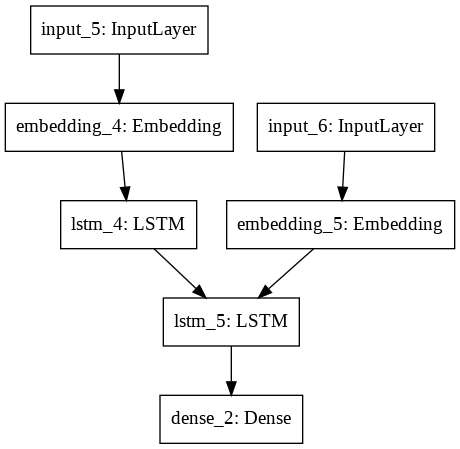

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 10

In [ ]:
train_samples,val_samples

(95880, 23970)

In [ ]:
model_lite = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
749/749 [==============================] - 272s 354ms/step - loss: 2.1962 - val_loss: 1.6026
Epoch 2/10
749/749 [==============================] - 260s 348ms/step - loss: 1.4767 - val_loss: 1.2964
Epoch 3/10
749/749 [==============================] - 260s 347ms/step - loss: 1.1767 - val_loss: 1.1318
Epoch 4/10
749/749 [==============================] - 261s 349ms/step - loss: 0.9756 - val_loss: 1.0224
Epoch 5/10
749/749 [==============================] - 260s 348ms/step - loss: 0.8183 - val_loss: 0.9497
Epoch 6/10
749/749 [==============================] - 259s 346ms/step - loss: 0.6898 - val_loss: 0.9029
Epoch 7/10
749/749 [==============================] - 259s 345ms/step - loss: 0.5838 - val_loss: 0.8708
Epoch 8/10
749/749 [==============================] - 261s 349ms/step - loss: 0.4971 - val_loss: 0.8537
Epoch 9/10
749/749 [==============================] - 262s 350ms/step - loss: 0.4252 - val_loss: 0.8442
Epoch 10/10
749/749 [==============================] - 262s 349m

In [ ]:
model.save_weights('nmt_weights.h5')

In [ ]:
model.save_weights('machine_translation.h5')

##Generate Translation

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Spanish Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Spanish Translation:', decoded_sentence[:-4])

Input English sentence: i have never seen a red refrigerator
Actual Spanish Translation:  nunca he visto un frigorã­fico rojo 
Predicted Spanish Translation:  nunca he visto un frigo rojo 
